In [1]:
%pip install --upgrade --quiet langchain-community langchainhub langgraph langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.2/413.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
api_key = userdata.get('GROQ_API_KEY_3')

In [3]:
from typing_extensions import Annotated, TypedDict, List

In [4]:
from langchain.prompts import ChatPromptTemplate

In [5]:
from langchain.chains import create_sql_query_chain

In [6]:
from langchain_groq import ChatGroq
llm = ChatGroq(temperature=0, model="llama-3.3-70b-versatile", api_key = userdata.get('GROQ_API_KEY'))

In [7]:
class ClassifyInput(TypedDict):
    """Classify the input type."""
    input_type: Annotated[str, "Only takes values: 'ingestion' or 'chat'"]

In [8]:
class Transaction(TypedDict):
    """Transaction details."""
    date: Annotated[str, "The date of the transaction in 'YYYY-MM-DD' format."]
    amount: Annotated[float, "The amount spent in the transaction."]
    vendor: Annotated[str, "The name of the vendor or store where the transaction occurred."]
    description: Annotated[str, "A brief description of the transaction, such as items purchased."]


## Natural Language Classifcation

In [9]:
classify_llm = llm.with_structured_output(ClassifyInput)

# Define the prompt for classification task
prompt = ChatPromptTemplate.from_messages([
    ("system", "Classify the following query as either 'ingestion' or 'chat'."),
    ("human", "Query: {chunk}\n\nClassify the query as either 'ingestion' or 'chat'.")
])

# Function to classify the input
def classify_query(chunk: str) -> ClassifyInput:
    # Invoke the structured LLM model to get the classification result
    response = classify_llm.invoke(prompt.format(chunk=chunk))

    # The response will be in the form of a structured output (ClassifyInput)
    return response['input_type']

In [ ]:
classify_query("I bought a laptop at Best Buy on 2025-02-21 for $799.99. The laptop is an HP Spectre x360.")

'ingestion'

## Schema Extraction

In [10]:
# Set up the LLM with structured output
transaction_llm = llm.with_structured_output(Transaction)

# Define the prompt
prompt = ChatPromptTemplate.from_messages([
    ("system", "Extract the transaction details from the given text input. Focus on date, amount, vendor, and description."),
    ("human", "Text: {chunk}\n\nExtract the following details:\n- Date\n- Amount\n- Vendor\n- Description.")
])

In [11]:
# Function to process the input text and extract transaction details
def extract_transaction_details(chunk: str) -> Transaction:
    # Invoke the structured LLM model to get the structured output (JSON format)
    response = transaction_llm.invoke(prompt.format(chunk=chunk))

    # The response will be in the form of a structured output (Transaction)
    return response

In [ ]:
|extract_transaction_details("I bought a laptop at Best Buy on 2025-02-21 for $799.99. The laptop is an HP Spectre x360")

{'date': '2025-02-21',
 'amount': 799.99,
 'vendor': 'Best Buy',
 'description': 'HP Spectre x360 laptop'}

## Ingestion Pipeline

In [12]:
import os
import sqlite3
from dotenv import load_dotenv



# Set up the SQLite database to store transaction details
def create_transaction_table():
    # Connect to the SQLite database (this will create the database file if it doesn't exist)
    conn = sqlite3.connect('transactions.db')
    cursor = conn.cursor()

    # Create the transactions table if it doesn't exist
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS transactions (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            date TEXT,
            amount REAL,
            vendor TEXT,
            description TEXT
        )
    ''')

    # Commit changes and close the connection
    conn.commit()
    conn.close()

def insert_transaction_to_db(transaction: Transaction):
    # Connect to the SQLite database
    conn = sqlite3.connect('transactions.db')
    cursor = conn.cursor()

    # Insert the extracted transaction details into the database
    cursor.execute('''
        INSERT INTO transactions (date, amount, vendor, description)
        VALUES (?, ?, ?, ?)
    ''', (transaction['date'], transaction['amount'], transaction['vendor'], transaction['description']))

    # Commit changes and close the connection
    conn.commit()
    conn.close()

def process_and_store_transaction(chunk: str):
    # Extract transaction details
    transaction = extract_transaction_details(chunk)

    # Insert the extracted details into the database
    insert_transaction_to_db(transaction)

# Create the transaction table if not already created
create_transaction_table()


In [13]:
transaction_texts = [
    "I had dinner at The Bistro on 2025-02-13 for $25.50. The meal included pasta, salad, and a drink.",
    "I purchased a book from Amazon on 2025-02-14 for $15.00. The book was 'Python Programming for Beginners'.",
    "I filled up my car at Shell Gas Station on 2025-02-15 for $40.00. The fuel was premium unleaded.",
    "I subscribed to Netflix on 2025-02-16 for $12.99. The subscription is for one month of standard service.",
    "I bought a concert ticket for the Coldplay show on 2025-02-17 for $85.00. The ticket was for section A, row 10.",
    "I had lunch at Starbucks on 2025-02-18 for $8.75. I ordered a sandwich and coffee.",
    "I bought a jacket at Macy's on 2025-02-19 for $55.99. The jacket is from the new winter collection.",
    "I took a taxi ride on 2025-02-20 for $22.50. The ride was from downtown to the airport.",
    "I bought a laptop at Best Buy on 2025-02-21 for $799.99. The laptop is an HP Spectre x360.",

]

for tn in transaction_texts:
  process_and_store_transaction(tn)
  print("database updated")


database updated
database updated
database updated
database updated
database updated
database updated
database updated
database updated
database updated


## Checking if the records are stored or not

In [14]:
import sqlite3

def check_records_in_db():
    # Connect to the SQLite database
    conn = sqlite3.connect('transactions.db')
    cursor = conn.cursor()

    # Fetch all records from the transactions table
    cursor.execute("SELECT * FROM transactions")
    records = cursor.fetchall()

    # Display the records
    if records:
        for record in records:
            print(f"ID: {record[0]}, Date: {record[1]}, Amount: {record[2]}, Vendor: {record[3]}, Description: {record[4]}")
    else:
        print("No records found.")

    # Close the connection
    conn.close()

# Call the function to check the records
check_records_in_db()


ID: 1, Date: 2025-02-13, Amount: 25.5, Vendor: The Bistro, Description: pasta, salad, and a drink
ID: 2, Date: 2025-02-14, Amount: 15.0, Vendor: Amazon, Description: Python Programming for Beginners book
ID: 3, Date: 2025-02-15, Amount: 40.0, Vendor: Shell Gas Station, Description: premium unleaded fuel
ID: 4, Date: 2025-02-16, Amount: 12.99, Vendor: Netflix, Description: one month of standard service
ID: 5, Date: 2025-02-17, Amount: 85.0, Vendor: unknown, Description: concert ticket for the Coldplay show, section A, row 10
ID: 6, Date: 2025-02-18, Amount: 8.75, Vendor: Starbucks, Description: a sandwich and coffee
ID: 7, Date: 2025-02-19, Amount: 55.99, Vendor: Macy's, Description: a jacket from the new winter collection
ID: 8, Date: 2025-02-20, Amount: 22.5, Vendor: taxi, Description: taxi ride from downtown to the airport
ID: 9, Date: 2025-02-21, Amount: 799.99, Vendor: Best Buy, Description: HP Spectre x360 laptop


## QnA (NL2SQL Pipeline)

In [15]:
from langchain import hub
query_prompt_template = hub.pull("langchain-ai/sql-agent-system-prompt")
assert len(query_prompt_template.messages) == 1

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [16]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///transactions.db")
print(db.dialect)
print(db.get_usable_table_names())

sqlite
['transactions']


In [17]:
db.get_table_info()

'\nCREATE TABLE transactions (\n\tid INTEGER, \n\tdate TEXT, \n\tamount REAL, \n\tvendor TEXT, \n\tdescription TEXT, \n\tPRIMARY KEY (id)\n)\n\n/*\n3 rows from transactions table:\nid\tdate\tamount\tvendor\tdescription\n1\t2025-02-13\t25.5\tThe Bistro\tpasta, salad, and a drink\n2\t2025-02-14\t15.0\tAmazon\tPython Programming for Beginners book\n3\t2025-02-15\t40.0\tShell Gas Station\tpremium unleaded fuel\n*/'

In [ ]:
system_message = query_prompt_template.format(dialect="SQLite", top_k="")

In [18]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [19]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [21]:
write_query({"question": "How much I paid for the Gas?"})

{'query': "SELECT name FROM sqlite_master WHERE type='table';"}

In [ ]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [ ]:
execute_query(write_query({"question": "what w?"}))ere the expenses in the Bistor

{'result': "[('transactions',), ('sqlite_sequence',)]"}

In [ ]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

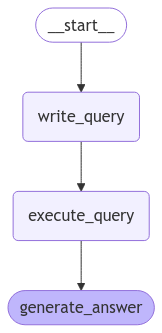

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
output = []
for step in graph.stream(
    {"question": "On which date, the expenses were lowest?, also mention the transaction"},
    stream_mode="updates",
):
    output.append(step)

print(output[-1]['generate_answer']["answer"])

The expenses were lowest on '2025-02-18' with a transaction of $8.75 for 'a sandwich and coffee' from 'Starbucks'.


In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x79e04793f4d0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x79e04793f4d0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x79e04793f4d0>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, prompt=system_message)

In [ ]:
question = "what were the expenses in the Bistor?"

for chunk in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values"):

    final_result = chunk

result = final_result["messages"][-1].content

In [ ]:
print(result)

The expense in the Bistro was $25.5.
